In [20]:
import numpy as np
import pandas as pd

# Load the necessary data (adjust paths if necessary)
sim_signups = pd.read_csv("simulated_advertiser_signups_2025_daily_with_ID.csv")
agent_salary_threshold = pd.read_csv("[BADSS case] Agent Salary and Eligibility Threshold - data.csv")
existing_agent_staffing = pd.read_csv("[BADSS case] Existing Agent Staffing - data.csv")

# Convert Sign_Up_Date to day-of-year for comparison (assumes sign-up dates are in a standard date format)
sim_signups['Sign_Up_Date'] = pd.to_datetime(sim_signups['Sign_Up_Date'])
sim_signups['Sign_Up_Day'] = sim_signups['Sign_Up_Date'].dt.dayofyear

# Set constants
agent_capacity_per_agent = 10     # Each agent can handle up to 10 advertisers at once
advertiser_lifecycle = 60         # Advertisers are in the system for 60 days before being removed
probabilities = [0.05, 0.15, 0.25, 0.25, 0.2, 0.1]   # Uplift probabilities
uplift_percentages = [0, 5, 10, 15, 20, 25]           # Corresponding uplift percentages

# List to store daily results for each country
daily_results = []

days_in_year = 365  # Number of simulation days in 2025

# Initialize metric variables
total_revenue = 0
total_cost = 0
total_net_profit = 0
total_utilization = 0
total_advertisers = 0
churned_advertisers = 0
active_advertisers = 0  # Active advertisers who are still in the system

# Run simulation for each country separately
for country in sim_signups['Country'].unique():
    # Get the initial number of agents and annual salary for the country
    existing_agents_count = int(existing_agent_staffing[existing_agent_staffing['Country'] == country]['Existing_Agent_Count'].values[0])
    agent_annual_salary = float(agent_salary_threshold[agent_salary_threshold['Country'] == country]['Annual_Agent_Salary_USD'].values[0])

    # Calculate daily wage cost for all agents (this is constant for the entire year)
    agent_daily_wage = agent_annual_salary / 365
    total_wage_cost_per_day = existing_agents_count * agent_daily_wage

    # Initialize variables for the simulation for this country
    available_agents = existing_agents_count
    waiting_pool = 0
    total_revenue_country = 0.0
    advertisers_info = {}   # key: advertiser_id, value: dict with 'Sign_Up_Day', 'Budget', 'Assigned'
    churned_advertisers_country = 0
    active_advertisers_country = 0

    # Simulate each day
    for day in range(1, days_in_year + 1):
        # Add new eligible advertisers ONLY if today is their sign-up day.
        new_advertisers = sim_signups[
            (sim_signups['Country'] == country) &
            (sim_signups['Sign_Up_Day'] == day)
        ]

        # Add each new advertiser into our tracker and waiting pool
        for _, advertiser in new_advertisers.iterrows():
            adv_id = advertiser['Advertiser_ID']
            advertisers_info[adv_id] = {
                'Sign_Up_Day': day,
                'Budget': advertiser['Projected_Annual_Budget'],
                'Assigned': False
            }
        waiting_pool += new_advertisers.shape[0]

        # Assign advertisers from the waiting pool to available agents.
        if available_agents > 0:
            max_assignable = available_agents * agent_capacity_per_agent
            assigned_advertisers = min(max_assignable, waiting_pool)
            waiting_pool -= assigned_advertisers
        else:
            assigned_advertisers = 0

        # Calculate uplift revenue for assigned advertisers
        assigned_ids = list(advertisers_info.keys())[:assigned_advertisers]
        uplift_revenue = 0.0
        for adv_id in assigned_ids:
            adv = advertisers_info[adv_id]
            if not adv['Assigned']:
                uplift = np.random.choice(uplift_percentages, p=probabilities)
                uplift_revenue += adv['Budget'] * (uplift / 100.0)
                adv['Assigned'] = True
        total_revenue_country += uplift_revenue

        # Remove advertisers from the tracker if they've been waiting/served for 60 days.
        completed_ids = [adv_id for adv_id, adv in advertisers_info.items() if (day - adv['Sign_Up_Day']) >= advertiser_lifecycle]
        for adv_id in completed_ids:
            adv = advertisers_info[adv_id]
            total_revenue_country += adv['Budget']
            churned_advertisers_country += 1  # Count churned advertisers
            del advertisers_info[adv_id]

        # Track active advertisers for churn rate
        active_advertisers_country += assigned_advertisers

        # Calculate net revenue by subtracting the fixed total wage cost for the country
        net_revenue = total_revenue_country - total_wage_cost_per_day * day

        # Record the daily results in a list
        daily_results.append({
            'Day': day,
            'Country': country,
            'Assigned_Advertisers': assigned_advertisers,
            'Available_Agents': available_agents,
            'Waiting_Pool': waiting_pool,
            'Revenue': total_revenue_country,
            'Net_Revenue': net_revenue
        })

    # Metrics for this country
    total_revenue += total_revenue_country
    total_cost += total_wage_cost_per_day * days_in_year
    total_net_profit += total_revenue_country - total_cost
    total_utilization += sum([result['Assigned_Advertisers'] for result in daily_results if result['Country'] == country]) / (available_agents  * days_in_year)

    # Final print for the country
    churn_rate = churned_advertisers_country / active_advertisers_country if active_advertisers_country > 0 else 0
    utilization_rate = sum([result['Assigned_Advertisers'] for result in daily_results if result['Country'] == country]) / (available_agents  * days_in_year)

    print(f"\nMetrics for {country}:")
    print(f"  Total Revenue: ${total_revenue_country:.2f}")
    print(f"  Total Cost: ${total_wage_cost_per_day * days_in_year:.2f}")
    print(f"  Net Profit: ${total_revenue_country - total_wage_cost_per_day * days_in_year:.2f}")
    print(f"  Utilization Rate: {utilization_rate * 100:.2f}%")

# Final aggregate metrics across all countries
print("\nAggregate Metrics for All Countries:")
print(f"  Total Revenue: ${total_revenue:.2f}")
print(f"  Total Cost: ${total_cost:.2f}")
print(f"  Net Profit: ${total_net_profit:.2f}")
print(f"  Average Utilization Rate: {total_utilization / len(sim_signups['Country'].unique()) * 100:.2f}%")




Metrics for USA:
  Total Revenue: $2520737998.42
  Total Cost: $50674092.00
  Net Profit: $2470063906.42
  Utilization Rate: 25.19%

Metrics for UK:
  Total Revenue: $932751509.25
  Total Cost: $30421850.00
  Net Profit: $902329659.25
  Utilization Rate: 16.84%

Metrics for Germany:
  Total Revenue: $779491369.75
  Total Cost: $30899456.00
  Net Profit: $748591913.75
  Utilization Rate: 15.08%

Metrics for India:
  Total Revenue: $1251672316.57
  Total Cost: $6042504.00
  Net Profit: $1245629812.57
  Utilization Rate: 27.08%

Metrics for Brazil:
  Total Revenue: $931314588.13
  Total Cost: $5282550.00
  Net Profit: $926032038.13
  Utilization Rate: 52.68%

Metrics for Japan:
  Total Revenue: $630487461.77
  Total Cost: $14714865.00
  Net Profit: $615772596.77
  Utilization Rate: 27.33%

Metrics for Australia:
  Total Revenue: $406067909.52
  Total Cost: $19577250.00
  Net Profit: $386490659.52
  Utilization Rate: 14.60%

Metrics for Canada:
  Total Revenue: $528294445.29
  Total Cost:

KeyboardInterrupt: 

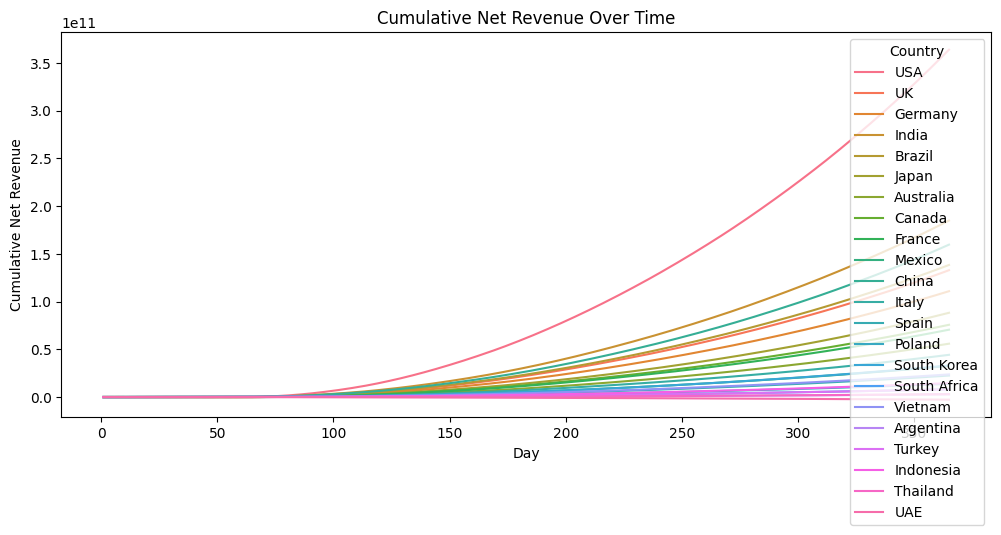

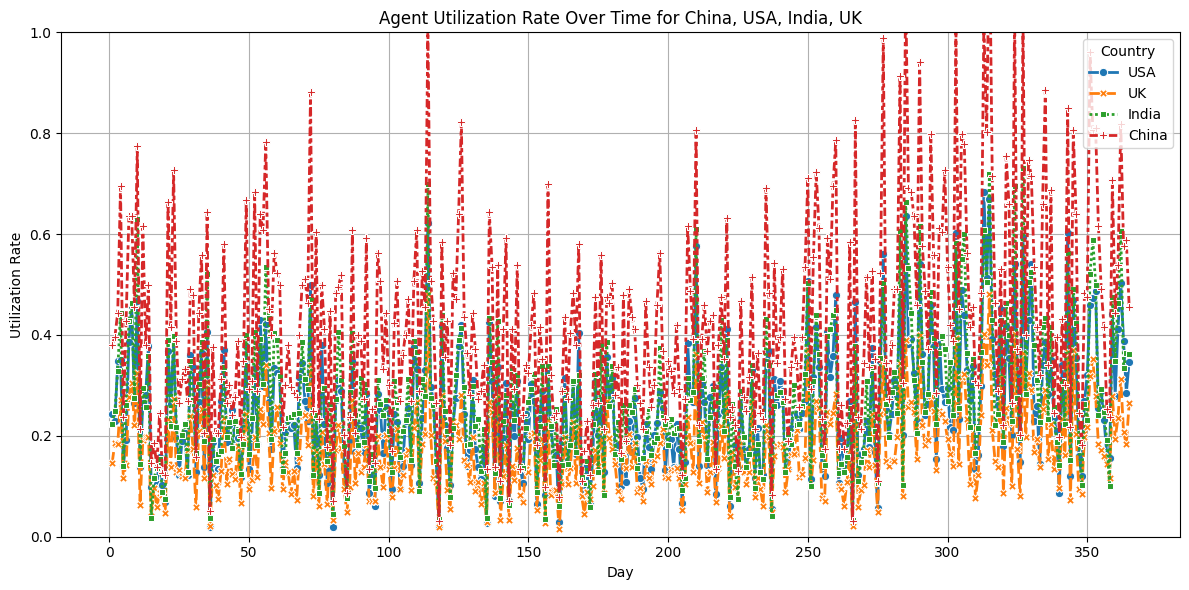

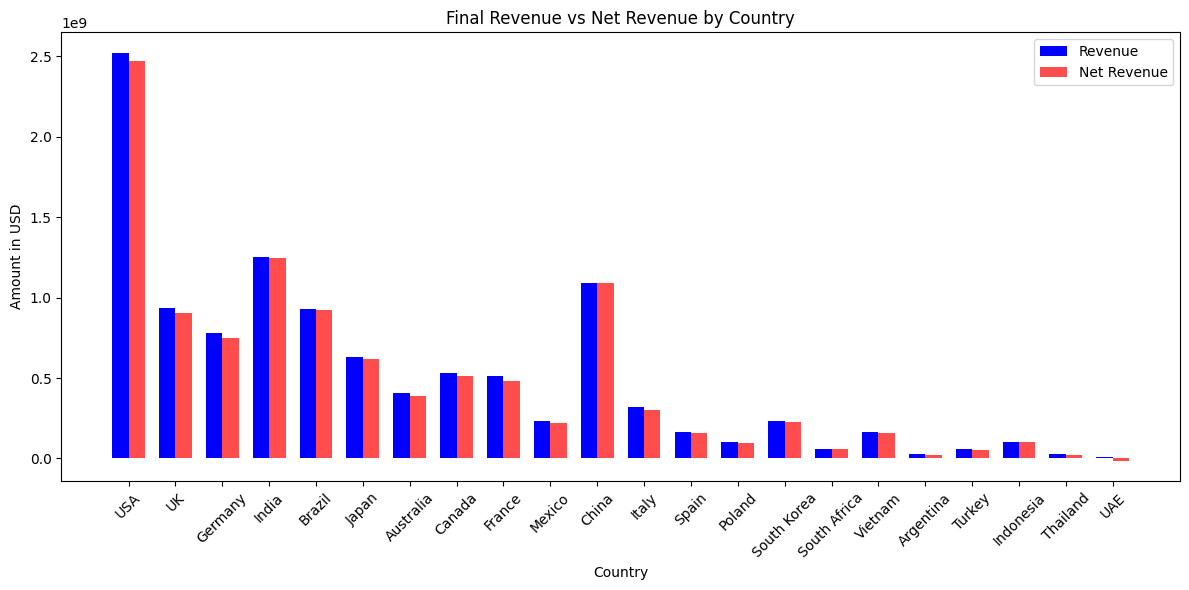

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

daily_agent_plan["Day"] = daily_agent_plan["Day"].astype(int)

# Visualizes daily cumulative net income trends
daily_agent_plan["Cumulative_Net_Revenue"] = daily_agent_plan.groupby("Country")["Net_Revenue"].cumsum()

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_agent_plan, x="Day", y="Cumulative_Net_Revenue", hue="Country")
plt.title("Cumulative Net Revenue Over Time")
plt.xlabel("Day")
plt.ylabel("Cumulative Net Revenue")
plt.legend(title="Country")
plt.show()

# Visualize the agent utilization
# Filter the data for China, USA, India, and UK
countries_of_interest = ['China', 'USA', 'India', 'UK']
filtered_data = daily_agent_plan[daily_agent_plan['Country'].isin(countries_of_interest)]

# Plot the agent utilization for China, USA, India, and UK
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=filtered_data,
    x="Day",
    y="Agent_Utilization",
    hue="Country",
    style="Country",    # Different line styles for each country
    markers=True,       # Show markers for each point
    dashes=True,        # Use dashed lines where applicable
    lw=2               # Increase line width for better visibility
)
plt.title("Agent Utilization Rate Over Time for China, USA, India, UK")
plt.xlabel("Day")
plt.ylabel("Utilization Rate")
plt.ylim(0, 1)  # 0% ~ 100%
plt.legend(title="Country", loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualize final income comparisons at country level
final_results = daily_agent_plan[daily_agent_plan["Day"] == days_in_year][["Country", "Revenue", "Net_Revenue"]]

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.35

# Generate the positions for the bars
index = np.arange(len(final_results))  # Country positions on x-axis

# Create the bar for Revenue (blue)
plt.bar(index, final_results["Revenue"], bar_width, color="blue", label="Revenue")

# Create the bar for Net Revenue (red), with a slight shift on the x-axis
plt.bar(index + bar_width, final_results["Net_Revenue"], bar_width, color="red", label="Net Revenue", alpha=0.7)

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Amount in USD')
plt.title('Final Revenue vs Net Revenue by Country')

# Add the x-ticks for the countries, rotated for clarity
plt.xticks(index + bar_width / 2, final_results["Country"], rotation=45)

# Add the legend
plt.legend()

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
